<a href="https://colab.research.google.com/github/marektopolewski/icl-nlp-humour/blob/main/approach1_pretrained_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [2]:
# You will need to download any word embeddings required for your code, e.g.:

# !wget -q http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !rm glove.6B.zip

!wget -q https://cs.rochester.edu/u/nhossain/semeval-2020-task-7-dataset.zip
!unzip -q semeval-2020-task-7-dataset.zip
!rm semeval-2020-task-7-dataset.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

! pip -q install transformers tqdm

     |████████████████████████████████| 1.9MB 4.1MB/s 
     |████████████████████████████████| 890kB 30.8MB/s 
     |████████████████████████████████| 3.2MB 39.1MB/s 


In [3]:
# Imports

import torch
import torch.nn as nn
from torch.nn.utils.clip_grad import clip_grad_norm_
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split, DataLoader
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import torch.optim as optim
import codecs
from tqdm import tqdm
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [16]:
# Number of epochs
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 2e-05
ADAM_EPSILON = 1e-8
GRAD_CLIP = 5

# Model params
context_types = ['none', 'masked', 'original']
CONTEXT_TYPE = context_types[2]
CLASSIFICATION_HEAD = True

# Proportion of training data for train compared to dev
TRAINING_RATIO = 0.8
AUG_RANDOM_FLIP = True

# Pre-trained models
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# transformer = RobertaModel.from_pretrained("roberta-base", output_hidden_states=True)

#### Approach 1: Using pre-trained representations

In [20]:
########################################### LOAD DATA ##############################################
import re

# We create a Dataset so we can create minibatches
class Task2Dataset(Dataset):

    def __init__(self, df):
      cust_tokenize = lambda x: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x))

      self.x_edit_1 = [cust_tokenize(x) for x in df.edit_sentence1.tolist()]
      self.x_masked_1 = [cust_tokenize(x) for x in df.masked1.tolist()]
      self.y_grade_1 = df.meanGrade1.tolist()

      self.x_edit_2 = [cust_tokenize(x) for x in df.edit_sentence2.tolist()]
      self.x_masked_2 = [cust_tokenize(x) for x in df.masked2.tolist()]
      self.y_grade_2 = df.meanGrade2.tolist()

      self.x_original = [cust_tokenize(x) for x in df.original.tolist()]
      self.y_label = df.label.tolist()

    def __len__(self):
        return len(self.y_label)

    def __getitem__(self, item):
        # convert to 0,1 labels
        label = self.y_label[item] - 1

        # randomly swap the order of sentences
        flip = np.random.choice([True, False]) if AUG_RANDOM_FLIP else False

        return { 'x_edit_1':      getattr(self, f'x_edit_{2 if flip else 1}')[item],
                 'x_masked_1':    getattr(self, f'x_masked_{2 if flip else 1}')[item],
                 'y_grade_1':     getattr(self, f'y_grade_{2 if flip else 1}')[item],
                 'x_edit_2':      getattr(self, f'x_edit_{1 if flip else 2}')[item],
                 'x_masked_2':    getattr(self, f'x_masked_{1 if flip else 2}')[item],
                 'y_grade_2':     getattr(self, f'y_grade_{1 if flip else 2}')[item],
                 'x_original':    self.x_original[item],
                 'y_label':       1 - label if flip else label }

def preprocess_data(df, drop_zero, keep_id=False):
  print('[preprocess] started... ', end='')

  # create sentences by replacing <word/> words
  for row_idx, row in df.iterrows():
    original = row['original1'].strip()
    orig_word = re.search("<(.*)/>", original)
    orig_seq = f'{tokenizer.sep_token} {orig_word} {tokenizer.sep_token}'
    df.loc[row_idx, 'original'] = re.sub("<.*/>", orig_seq, original)
    for i in ['1', '2']:
      edit_seq = f'{tokenizer.sep_token} {row[f"edit{i}"]} {tokenizer.sep_token}'
      mask_seq = f'{tokenizer.sep_token} {tokenizer.mask_token} {tokenizer.sep_token}'
      df.loc[row_idx, f'edit_sentence{i}'] = re.sub("<.*/>", edit_seq, original)
      df.loc[row_idx, f'masked{i}'] = re.sub("<.*/>", mask_seq, original)

  # keep only the relevant columns  
  cols_to_drop = list(df.columns)
  for i in ['1', '2']:
    cols_to_drop.remove(f'edit_sentence{i}')
    cols_to_drop.remove(f'masked{i}')
    cols_to_drop.remove(f'meanGrade{i}')
  cols_to_drop.remove('original')
  cols_to_drop.remove('label')
  if keep_id:
    cols_to_drop.remove('id')
  df = df.drop(columns=cols_to_drop)

  # remove rows with label = 0 (not assessed in the task)
  if drop_zero:
    df = df.drop(df[df['label'] == 0].index)

  print('done.')
  return df

def pad_column(col):
  max_len = max([len(x) for x in col])
  for k, v in enumerate(col):
    col[k] += [tokenizer.pad_token_id] * (max_len - len(v))
  return col

def pad_batch(batch):
  x_edit_1 = pad_column([row['x_edit_1'] for row in batch])
  x_masked_1 = pad_column([row['x_masked_1'] for row in batch])
  y_grade_1 = [row['y_grade_1'] for row in batch]
  x_edit_2 = pad_column([row['x_edit_2'] for row in batch])
  x_masked_2 = pad_column([row['x_masked_2'] for row in batch])
  y_grade_2 = [row['y_grade_2'] for row in batch]
  x_original = pad_column([row['x_original'] for row in batch])
  y_label = [row['y_label'] for row in batch]
  return {'x_edit_1': x_edit_1, 'x_masked_1': x_masked_1, 'y_grade_1': y_grade_1,
          'x_edit_2': x_edit_2, 'x_masked_2': x_masked_2, 'y_grade_2': y_grade_2,
          'x_original': x_original, 'y_label': y_label}


# Load data from CSV
train_df = pd.read_csv('semeval-2020-task-7-dataset/subtask-2/train.csv')
funlines_df = pd.read_csv('semeval-2020-task-7-dataset/subtask-2/train_funlines.csv')
dev_df = pd.read_csv('semeval-2020-task-7-dataset/subtask-2/dev.csv')
print('Data loaded from CSV.')

# Preprocess the data -> creates 2x (edit_sentence, masked_sentence, grade) + original + label
funlines_df2 = preprocess_data(funlines_df, drop_zero=True)
train_df2 = preprocess_data(train_df, drop_zero=True)
dev_df2 = preprocess_data(dev_df, drop_zero=True)
dataset = Task2Dataset(pd.concat([train_df2, funlines_df2, dev_df2]))
print('Dataset built.')

# Perform the train/eval split
train_size = round(len(dataset) * TRAINING_RATIO)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, (train_size, eval_size))

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=pad_batch)
eval_loader = DataLoader(eval_dataset, shuffle=False, batch_size=BATCH_SIZE, collate_fn=pad_batch)
print('Train and evaluation split data loaders generated.')

Data loaded from CSV.
[preprocess] started... done.
[preprocess] started... done.
[preprocess] started... done.
Dataset built.
Train and evaluation split data loaders generated.


#### Visualisations

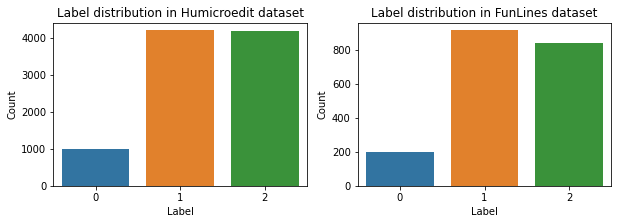

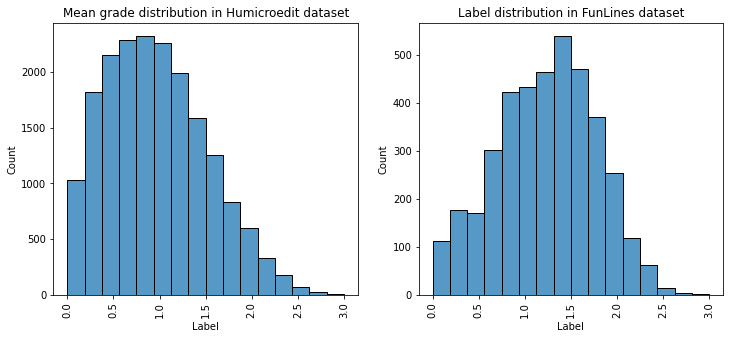

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.countplot(ax=ax[0], x=train_df['label'])
ax[0].set_title("Label distribution in Humicroedit dataset")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")
sns.countplot(ax=ax[1], x=funlines_df['label'])
ax[1].set_title("Label distribution in FunLines dataset");
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(ax=ax[0], bins=16, kde=False,
             x=pd.concat([train_df['meanGrade1'], train_df['meanGrade2']]))
ax[0].set_title("Mean grade distribution in Humicroedit dataset")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")
sns.histplot(ax=ax[1], bins=16, kde=False,
             x=pd.concat([funlines_df['meanGrade1'], funlines_df['meanGrade2']]))
ax[1].set_title("Label distribution in FunLines dataset");
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
plt.setp(ax[0].get_xticklabels(), rotation=90)
plt.setp(ax[1].get_xticklabels(), rotation=90)
fig.show()

#### Model

In [25]:
def get_span_mask(span, sent_len):
    bsz = span.shape[0]
    index_tensor = (
        torch.tensor(list(range(sent_len)), device=device)
        .unsqueeze(0)
        .expand(bsz, sent_len)
    )
    start_index, end_index = span.split(1, dim=-1)
    start_index = start_index + 1
    end_index = end_index - 1

    start_mask = (index_tensor - start_index) >= 0
    end_mask = (index_tensor - end_index) <= 0
    span_mask = start_mask & end_mask

    return span_mask

In [26]:
# DEFINE MODEL

class ColBERT(nn.Module):

  def __init__(self, tokenizer, transformer, context=False, classification=False, simple_feature=False):
    super(ColBERT, self).__init__()
    self.tokenizer = tokenizer
    self.transformer = transformer
    self.context = context                # combine edits with context
    self.classification = classification  # use classfication head
    self.simple_feature = simple_feature  # use simplified feature vector (classifcation only)

    hid_size = transformer.config.hidden_size
    feature_size = 4 if not simple_feature else 1

    if not self.classification:
      self.head = nn.Linear(hid_size * (feature_size if self.context else 1), 1)
    else:
      self.head = nn.Sequential(
          nn.Dropout(0.2),
          nn.Linear(hid_size * feature_size, 1))

    if self.context and self.classification:
      self.pool = nn.Linear(hid_size * feature_size * 2, hid_size * feature_size)


  def forward(self, edit1, context1, edit2, context2):
    if self.context:
      if self.classification:
        return self._classify_context(edit1, context1, edit2, context2)
      else:
        return self._regress_context(edit1, context1, edit2, context2)
    else:
      if self.classification:
        return self._classify(edit1, edit2)
      else:
        return self._regress(edit1, edit2)      
    raise Exception('Invalid model config')

  def _regress_context(self, edit1, context1, edit2, context2):
    edit1_emb, edit2_emb = self._embed(edit1), self._embed(edit2)
    context1_emb, context2_emb = self._embed(context1), self._embed(context2)
    h1 = self._make_feature(edit1_emb, context1_emb)
    h2 = self._make_feature(edit2_emb, context2_emb)
    grade1 = self.head(h1).squeeze()
    grade2 = self.head(h2).squeeze()
    labels = torch.argmax(torch.stack([grade1, grade2], -1), dim=-1)
    return labels, grade1, grade2
  
  def _regress(self, edit1, edit2):
    edit1_emb = self._embed(edit1)
    edit2_emb = self._embed(edit2)
    grade1 = self.head(edit1_emb).squeeze()
    grade2 = self.head(edit2_emb).squeeze()
    labels = torch.argmax(torch.stack([grade1, grade2], -1), dim=-1)
    return labels, grade1, grade2
  
  def _classify_context(self, edit1, context1, edit2, context2):
    edit1_emb = self._embed(edit1)
    edit2_emb = self._embed(edit2)
    context1_emb = self._embed(context1)
    context2_emb = self._embed(context2)
    h1 = self._make_feature(edit1_emb, context1_emb)
    h2 = self._make_feature(edit2_emb, context2_emb)
    h = self.pool(torch.cat([h1, h2], -1))
    return self.head(h), None, None
    
  def _classify(self, edit1, edit2):
    edit1_emb = self._embed(edit1)
    edit2_emb = self._embed(edit2)
    h = self._make_feature(edit1_emb, edit2_emb)
    return self.head(h), None, None
  
  def _embed(self, inp):
    inp_mask = (inp != self.tokenizer.pad_token_id) & (inp != self.tokenizer.sep_token_id)
    sep_mask = inp == self.tokenizer.sep_token_id
        
    outputs = self.transformer(inp, attention_mask=inp_mask)
    last_hidden_state = outputs.last_hidden_state

    span = torch.nonzero(input=sep_mask, as_tuple=True)[1].view(-1, 2)
    span_mask = get_span_mask(span=span, sent_len=inp.shape[-1])

    out = self._pool(last_hidden_state, span_mask)

    return out

  def _make_feature(self, u, v):
    if self.simple_feature:
      return torch.cat([u - v], -1)
    return torch.cat([u, v, (u - v).abs(), u * v], -1)

  @staticmethod
  def _pool(sequence, mask):
    if len(sequence.shape) == 2:
      return sequence
    if mask is None:
      mask = torch.ones(sequence.shape[:2], device=device)
    if len(mask.size()) < 3:
      mask = mask.unsqueeze(dim=-1)
    pad_mask = mask == 0
    sequence = sequence.masked_fill(pad_mask, 0)
    seq_emb = sequence.sum(dim=1) / mask.sum(dim=1).float()
    return seq_emb
  
  @staticmethod
  def _soft_argmax(u, v, threshold=None):
    """"
    Assign 0 instead of 1 (for u) or 2 (for v) if difference below threshold.
    Ultimately not used with (threshold != None) because we disregard 0 labels.
    """
    argmax = torch.argmax(torch.stack([u, v], -1), dim=-1) + 1
    if not threshold:
      return argmax
    diff_mask = (u - v).abs() <= threshold
    return argmax.masked_fill(diff_mask, 0)

In [27]:
# How we print the model performance
def model_performance(output, target, size, print_output=False):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct_answers = (output == target)
    correct = sum(correct_answers)
    acc = np.true_divide(correct, size)

    if print_output:
        print(f'| Acc: {acc:.2f} ')

    return correct, acc

def preds_to_lables(x):
  return (nn.Sigmoid()(x) > 0.5).long()

In [28]:
# We evaluate performance on our dev set
def eval(data_iter, model, context_type='none', classification=False):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
  
          # Extract relevant data fields and cast to tensors
          edit1 = torch.LongTensor(batch['x_edit_1']).to(device)
          edit2 = torch.LongTensor(batch['x_edit_2']).to(device)
          y_label_true = torch.FloatTensor(batch['y_label']).to(device)
          if context_type == 'masked':
            context1 = torch.LongTensor(batch['x_masked_1']).to(device)
            context2 = torch.LongTensor(batch['x_masked_2']).to(device)
          elif context_type == 'original':
            context1 = context2 = torch.LongTensor(batch['x_original']).to(device)
          else:
            context1 = context2 = None
    
          if classification:
            y_grade1_true = y_grade2_true = None
          else:
            y_grade1_true = torch.FloatTensor(batch['y_grade_1']).to(device)
            y_grade2_true = torch.FloatTensor(batch['y_grade_2']).to(device)
      
          batch_len = len(y_label_true)
          optimizer.zero_grad()

          # Forward pass
          y_label_pred, y_grade1_pred, y_grade2_pred = model(edit1, context1, edit2, context2)
          y_label_pred = y_label_pred.squeeze(-1)
    
          # Calculate regression loss
          if not classification:
            if batch_len == 1:
              y_grade1_pred = y_grade1_pred.unsqueeze(-1)
              y_grade2_pred = y_grade2_pred.unsqueeze(-1)
            loss_fn = nn.MSELoss(reduction="sum")
            loss1 = loss_fn(y_grade1_pred, y_grade1_true)
            loss2 = loss_fn(y_grade2_pred, y_grade2_true)
            loss = (loss1 + loss2)
            label_preds = y_label_pred.detach().cpu().numpy()
          # Calculate classification loss
          else:
            loss_fn = nn.BCEWithLogitsLoss(reduction="sum")
            loss = loss_fn(y_label_pred, y_label_true)
            label_preds = preds_to_lables(y_label_pred.detach().cpu()).numpy()

          # Logging
          label_true = y_label_true.detach().cpu().numpy()
          correct, __ = model_performance(label_preds, label_true, batch_len)
          epoch_loss += loss.item()
          epoch_correct += correct
          no_observations += batch_len

          # Save labels
          pred_all = np.append(pred_all, label_preds)
          trg_all = np.append(trg_all, label_true)

    return epoch_loss/no_observations, epoch_correct/no_observations, pred_all, trg_all

In [29]:
# We define our training loop
def train(train_iter, dev_iter, model, optimizer, number_epoch=10, context_type='none',
          classification=False, save_best=False):
  """
  Training loop for the model, which calls on eval to evaluate after each epoch
  """

  print(f"Training model - classification {classification}, context {context_type}")
  train_losses, valid_losses = [], []
  train_accs, valid_accs = [], []
  best_valid_acc = 0

  for epoch in range(1, number_epoch+1):
    
    model.train()
    
    epoch_loss = 0
    epoch_correct = 0
    no_observations = 0  # Observations used for training so far

    for batch in train_iter:

      # Extract relevant data fields and cast to tensors
      edit1 = torch.LongTensor(batch['x_edit_1']).to(device)
      edit2 = torch.LongTensor(batch['x_edit_2']).to(device)
      y_label_true = torch.FloatTensor(batch['y_label']).to(device)
      if context_type == 'masked':
        context1 = torch.LongTensor(batch['x_masked_1']).to(device)
        context2 = torch.LongTensor(batch['x_masked_2']).to(device)
      elif context_type == 'original':
        context1 = context2 = torch.LongTensor(batch['x_original']).to(device)
      else:
        context1 = context2 = None

      if classification:
        y_grade1_true = y_grade2_true = None
      else:
        y_grade1_true = torch.FloatTensor(batch['y_grade_1']).to(device)
        y_grade2_true = torch.FloatTensor(batch['y_grade_2']).to(device)
  
      batch_len = len(y_label_true)
      optimizer.zero_grad()

      # Forward pass
      y_label_pred, y_grade1_pred, y_grade2_pred = model(edit1, context1, edit2, context2)
      y_label_pred = y_label_pred.squeeze(-1)

      # Calculate regression loss
      if not classification:
        if batch_len == 1:
          y_grade1_pred = y_grade1_pred.unsqueeze(-1)
          y_grade2_pred = y_grade2_pred.unsqueeze(-1)
        loss_fn = nn.MSELoss(reduction="sum")
        loss1 = loss_fn(y_grade1_pred, y_grade1_true)
        loss2 = loss_fn(y_grade2_pred, y_grade2_true)
        loss = (loss1 + loss2)
        label_preds = y_label_pred.detach().cpu().numpy()
      # Calculate classification loss
      else:
        loss_fn = nn.BCEWithLogitsLoss(reduction="sum")
        loss = loss_fn(y_label_pred, y_label_true)
        label_preds = preds_to_lables(y_label_pred.detach().cpu()).numpy()

      # Backward pass
      loss.backward()
      sum_grad = 0
      clip_grad_norm_(model.parameters(), GRAD_CLIP)
      optimizer.step()

      # Logging
      correct, __ = model_performance(label_preds, y_label_true.detach().cpu().numpy(), batch_len)
      epoch_loss += loss.item()
      epoch_correct += correct
      no_observations += batch_len
  
    valid_loss, valid_acc, __, __ = eval(dev_iter, model, context_type, classification)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    epoch_loss, epoch_acc = epoch_loss / no_observations, epoch_correct / no_observations
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
  
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train Accuracy: {epoch_acc:.2f} | \
    Val. Loss: {valid_loss:.2f} | Val. Accuracy: {valid_acc:.2f} |')

    if save_best and valid_acc > best_valid_acc:
      model_dir = './'
      torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))
      best_valid_acc = valid_acc
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
  ax[0].plot(train_losses, label='Training losses')
  ax[0].plot(valid_losses, label='Validation losses')
  ax[0].legend()
  ax[1].plot(train_accs, label='Training accuracies')
  ax[1].plot(valid_accs, label='Validation accuracies')
  ax[1].legend()
  fig.show()

In [ ]:
### Run tests
for context_type in context_types:
  for classification in [True, False]:
    transformer = RobertaModel.from_pretrained("roberta-base", output_hidden_states=True)
    model = ColBERT(tokenizer, transformer, context_type != 'none', classification).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
    train(train_loader, eval_loader, model, optimizer, EPOCHS, context_type, classification)

```
Training model - classification True, context none
| Epoch: 01 | Train Loss: 0.73 | Train Accuracy: 0.50 |     Val. Loss: 0.70 | Val. Accuracy: 0.50 |
| Epoch: 02 | Train Loss: 0.70 | Train Accuracy: 0.51 |     Val. Loss: 0.68 | Val. Accuracy: 0.56 |
| Epoch: 03 | Train Loss: 0.63 | Train Accuracy: 0.65 |     Val. Loss: 0.71 | Val. Accuracy: 0.58 |
| Epoch: 04 | Train Loss: 0.50 | Train Accuracy: 0.76 |     Val. Loss: 0.77 | Val. Accuracy: 0.60 |
| Epoch: 05 | Train Loss: 0.39 | Train Accuracy: 0.82 |     Val. Loss: 0.83 | Val. Accuracy: 0.62 |
| Epoch: 06 | Train Loss: 0.31 | Train Accuracy: 0.87 |     Val. Loss: 0.81 | Val. Accuracy: 0.62 |
| Epoch: 07 | Train Loss: 0.23 | Train Accuracy: 0.90 |     Val. Loss: 0.98 | Val. Accuracy: 0.63 |
| Epoch: 08 | Train Loss: 0.18 | Train Accuracy: 0.93 |     Val. Loss: 1.11 | Val. Accuracy: 0.63 |
| Epoch: 09 | Train Loss: 0.14 | Train Accuracy: 0.95 |     Val. Loss: 1.20 | Val. Accuracy: 0.63 |
| Epoch: 10 | Train Loss: 0.10 | Train Accuracy: 0.96 |     Val. Loss: 1.24 | Val. Accuracy: 0.64 |
Training model - classification False, context none
| Epoch: 01 | Train Loss: 0.90 | Train Accuracy: 0.51 |     Val. Loss: 0.74 | Val. Accuracy: 0.59 |
| Epoch: 02 | Train Loss: 0.67 | Train Accuracy: 0.61 |     Val. Loss: 0.64 | Val. Accuracy: 0.61 |
| Epoch: 03 | Train Loss: 0.50 | Train Accuracy: 0.68 |     Val. Loss: 0.71 | Val. Accuracy: 0.64 |
| Epoch: 04 | Train Loss: 0.39 | Train Accuracy: 0.72 |     Val. Loss: 0.50 | Val. Accuracy: 0.67 |
| Epoch: 05 | Train Loss: 0.32 | Train Accuracy: 0.75 |     Val. Loss: 0.51 | Val. Accuracy: 0.68 |
| Epoch: 06 | Train Loss: 0.27 | Train Accuracy: 0.79 |     Val. Loss: 0.52 | Val. Accuracy: 0.69 |
| Epoch: 07 | Train Loss: 0.23 | Train Accuracy: 0.81 |     Val. Loss: 0.74 | Val. Accuracy: 0.69 |
| Epoch: 08 | Train Loss: 0.19 | Train Accuracy: 0.84 |     Val. Loss: 0.45 | Val. Accuracy: 0.71 |
| Epoch: 09 | Train Loss: 0.16 | Train Accuracy: 0.86 |     Val. Loss: 0.42 | Val. Accuracy: 0.73 |
| Epoch: 10 | Train Loss: 0.13 | Train Accuracy: 0.88 |     Val. Loss: 0.44 | Val. Accuracy: 0.74 |
Training model - classification True, context masked
| Epoch: 01 | Train Loss: 0.77 | Train Accuracy: 0.50 |     Val. Loss: 0.99 | Val. Accuracy: 0.51 |
| Epoch: 02 | Train Loss: 0.72 | Train Accuracy: 0.55 |     Val. Loss: 0.68 | Val. Accuracy: 0.57 |
| Epoch: 03 | Train Loss: 0.59 | Train Accuracy: 0.70 |     Val. Loss: 0.70 | Val. Accuracy: 0.59 |
| Epoch: 04 | Train Loss: 0.46 | Train Accuracy: 0.80 |     Val. Loss: 0.78 | Val. Accuracy: 0.62 |
| Epoch: 05 | Train Loss: 0.36 | Train Accuracy: 0.85 |     Val. Loss: 1.13 | Val. Accuracy: 0.63 |
| Epoch: 06 | Train Loss: 0.28 | Train Accuracy: 0.89 |     Val. Loss: 1.06 | Val. Accuracy: 0.63 |
| Epoch: 07 | Train Loss: 0.21 | Train Accuracy: 0.92 |     Val. Loss: 1.20 | Val. Accuracy: 0.64 |
| Epoch: 08 | Train Loss: 0.16 | Train Accuracy: 0.94 |     Val. Loss: 1.95 | Val. Accuracy: 0.63 |
| Epoch: 09 | Train Loss: 0.13 | Train Accuracy: 0.96 |     Val. Loss: 2.48 | Val. Accuracy: 0.64 |
| Epoch: 10 | Train Loss: 0.12 | Train Accuracy: 0.97 |     Val. Loss: 2.27 | Val. Accuracy: 0.65 |
Training model - classification False, context masked
| Epoch: 01 | Train Loss: 0.90 | Train Accuracy: 0.53 |     Val. Loss: 0.68 | Val. Accuracy: 0.58 |
| Epoch: 02 | Train Loss: 0.68 | Train Accuracy: 0.61 |     Val. Loss: 0.60 | Val. Accuracy: 0.61 |
| Epoch: 03 | Train Loss: 0.54 | Train Accuracy: 0.68 |     Val. Loss: 0.57 | Val. Accuracy: 0.65 |
| Epoch: 04 | Train Loss: 0.43 | Train Accuracy: 0.72 |     Val. Loss: 0.67 | Val. Accuracy: 0.66 |
| Epoch: 05 | Train Loss: 0.35 | Train Accuracy: 0.75 |     Val. Loss: 0.57 | Val. Accuracy: 0.67 |
| Epoch: 06 | Train Loss: 0.30 | Train Accuracy: 0.78 |     Val. Loss: 0.47 | Val. Accuracy: 0.69 |
| Epoch: 07 | Train Loss: 0.26 | Train Accuracy: 0.80 |     Val. Loss: 0.46 | Val. Accuracy: 0.69 |
| Epoch: 08 | Train Loss: 0.23 | Train Accuracy: 0.81 |     Val. Loss: 0.63 | Val. Accuracy: 0.69 |
| Epoch: 09 | Train Loss: 0.20 | Train Accuracy: 0.83 |     Val. Loss: 0.52 | Val. Accuracy: 0.71 |
| Epoch: 10 | Train Loss: 0.17 | Train Accuracy: 0.85 |     Val. Loss: 0.44 | Val. Accuracy: 0.73 |
Training model - classification True, context original
| Epoch: 01 | Train Loss: 0.75 | Train Accuracy: 0.50 |     Val. Loss: 0.68 | Val. Accuracy: 0.57 |
| Epoch: 02 | Train Loss: 0.70 | Train Accuracy: 0.59 |     Val. Loss: 0.68 | Val. Accuracy: 0.58 |
| Epoch: 03 | Train Loss: 0.57 | Train Accuracy: 0.72 |     Val. Loss: 0.76 | Val. Accuracy: 0.60 |
| Epoch: 04 | Train Loss: 0.44 | Train Accuracy: 0.81 |     Val. Loss: 0.94 | Val. Accuracy: 0.62 |
| Epoch: 05 | Train Loss: 0.34 | Train Accuracy: 0.85 |     Val. Loss: 0.90 | Val. Accuracy: 0.63 |
| Epoch: 06 | Train Loss: 0.26 | Train Accuracy: 0.90 |     Val. Loss: 1.22 | Val. Accuracy: 0.63 |
| Epoch: 07 | Train Loss: 0.19 | Train Accuracy: 0.93 |     Val. Loss: 1.50 | Val. Accuracy: 0.65 |
| Epoch: 08 | Train Loss: 0.15 | Train Accuracy: 0.95 |     Val. Loss: 1.44 | Val. Accuracy: 0.65 |
| Epoch: 09 | Train Loss: 0.12 | Train Accuracy: 0.96 |     Val. Loss: 2.00 | Val. Accuracy: 0.65 |
| Epoch: 10 | Train Loss: 0.11 | Train Accuracy: 0.97 |     Val. Loss: 3.15 | Val. Accuracy: 0.64 |
Training model - classification False, context original
| Epoch: 01 | Train Loss: 0.89 | Train Accuracy: 0.52 |     Val. Loss: 0.83 | Val. Accuracy: 0.56 |
| Epoch: 02 | Train Loss: 0.69 | Train Accuracy: 0.60 |     Val. Loss: 0.66 | Val. Accuracy: 0.61 |
| Epoch: 03 | Train Loss: 0.53 | Train Accuracy: 0.67 |     Val. Loss: 0.53 | Val. Accuracy: 0.64 |
| Epoch: 04 | Train Loss: 0.42 | Train Accuracy: 0.72 |     Val. Loss: 0.55 | Val. Accuracy: 0.65 |
| Epoch: 05 | Train Loss: 0.35 | Train Accuracy: 0.75 |     Val. Loss: 0.49 | Val. Accuracy: 0.66 |
| Epoch: 06 | Train Loss: 0.29 | Train Accuracy: 0.77 |     Val. Loss: 0.49 | Val. Accuracy: 0.68 |
| Epoch: 07 | Train Loss: 0.26 | Train Accuracy: 0.80 |     Val. Loss: 0.48 | Val. Accuracy: 0.68 |
| Epoch: 08 | Train Loss: 0.23 | Train Accuracy: 0.81 |     Val. Loss: 0.46 | Val. Accuracy: 0.69 |
| Epoch: 09 | Train Loss: 0.20 | Train Accuracy: 0.83 |     Val. Loss: 0.46 | Val. Accuracy: 0.70 |
| Epoch: 10 | Train Loss: 0.18 | Train Accuracy: 0.85 |     Val. Loss: 0.46 | Val. Accuracy: 0.71 |
```

<figure>
    <img src="https://drive.google.com/uc?export=view&id=1x2eys3orwk1O762xD9zPdlDlcqNhOvtu" alt="Loss and accuracy curves 1" width=90% />
</figure>

<figure>
    <img src="https://drive.google.com/uc?export=view&id=10OZVj60MvDDPQt-0CKeI9C4c1hvyfQ_q" alt="Loss and accuracy curves 1" width=90% />
</figure>

<figure>
    <img src="https://drive.google.com/uc?export=view&id=1g2TWUuC7TUsA5TAcjlKCvP88Mb1zsztv" alt="Loss and accuracy curves 1" width=90% />
</figure>

### Train the best model

Training model - classification False, context none
| Epoch: 01 | Train Loss: 0.67 | Train Accuracy: 0.59 |     Val. Loss: 0.67 | Val. Accuracy: 0.63 |
| Epoch: 02 | Train Loss: 0.54 | Train Accuracy: 0.66 |     Val. Loss: 0.57 | Val. Accuracy: 0.64 |
| Epoch: 03 | Train Loss: 0.45 | Train Accuracy: 0.69 |     Val. Loss: 0.52 | Val. Accuracy: 0.69 |
| Epoch: 04 | Train Loss: 0.35 | Train Accuracy: 0.74 |     Val. Loss: 0.53 | Val. Accuracy: 0.70 |
| Epoch: 05 | Train Loss: 0.28 | Train Accuracy: 0.77 |     Val. Loss: 0.48 | Val. Accuracy: 0.72 |
| Epoch: 06 | Train Loss: 0.22 | Train Accuracy: 0.81 |     Val. Loss: 0.46 | Val. Accuracy: 0.74 |
| Epoch: 07 | Train Loss: 0.18 | Train Accuracy: 0.84 |     Val. Loss: 0.41 | Val. Accuracy: 0.75 |
| Epoch: 08 | Train Loss: 0.15 | Train Accuracy: 0.86 |     Val. Loss: 0.44 | Val. Accuracy: 0.75 |
| Epoch: 09 | Train Loss: 0.13 | Train Accuracy: 0.87 |     Val. Loss: 0.41 | Val. Accuracy: 0.76 |
| Epoch: 10 | Train Loss: 0.11 | Train Accuracy:

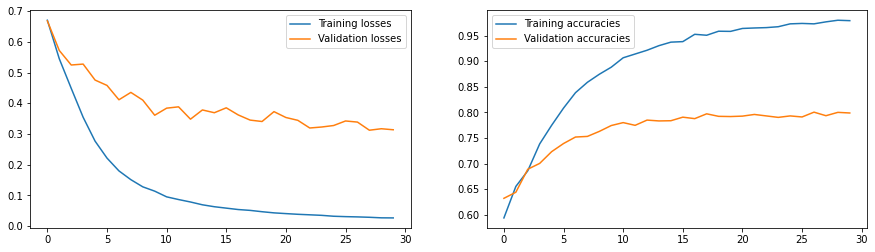

In [31]:
transformer = RobertaModel.from_pretrained("roberta-base", output_hidden_states=True)
model = ColBERT(tokenizer,
                transformer,
                context=False,
                classification=False,
                simple_feature=False)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
train(train_loader,
      eval_loader,
      model,
      optimizer
      number_epoch=30,
      context_type='none',
      classification=False,
      save_best=True)

### Testing

In [32]:
# Load data from CSV
test_df = pd.read_csv('semeval-2020-task-7-dataset/subtask-2/test.csv')
print('Data loaded from CSV.')

# Preprocess the data
test_df2 = preprocess_data(test_df, drop_zero=True, keep_id=True)
test_dataset = Task2Dataset(test_df2)
print('Dataset created.')

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_batch)
print('Test data loader generated.')

Data loaded from CSV.
[preprocess] started... done.
Dataset created.
Test data loader generated.


In [33]:
# model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
# model.to(device)
model.eval()
_, acc, preds, actual = eval(test_loader, model, context_type='none', classification=False)
print(f'Final accuracy on the test set: {acc}')

preds = (preds + 1).astype(int)
actual = (actual + 1).astype(int)

df = pd.DataFrame({'id': test_df2['id'], 'pred': preds, 'label': actual})
df.to_csv('task-2-output.csv', index=False)
print('Predictions exported to CSV.')

Final accuracy on the test set: 0.613013698630137
Predictions exported to CSV.
